In [1]:
import numpy as np

# Load and inspect the sequences file
sequence_file = "preprocessed/4jrb_sequences.npy"
sequences = np.load(sequence_file, allow_pickle=True)
print("Number of Sequences:", len(sequences))
print("Example Sequence Encoding:", len(sequences[0]))  # Check the first sequence


Number of Sequences: 1
Example Sequence Encoding: 418


In [2]:
# Load and inspect the coordinates file
coordinate_file = "preprocessed/4jrb_coordinates.npy"
coordinates = np.load(coordinate_file, allow_pickle=True)
print("Number of Coordinate Entries:", len(coordinates))
print("Example Coordinate Shape:", coordinates.shape)  # Shape of the first protein's coordinates


Number of Coordinate Entries: 398
Example Coordinate Shape: (398, 3)


In [3]:
import json
# Load and inspect the JSON file
combined_dataset = "JSON/4jrb_dataset.json"

with open(combined_dataset, "r") as f:
    dataset = json.load(f)

print("Number of Entries in Dataset:", len(dataset))
print("Example Entry:")
print(json.dumps(dataset[0], indent=4))  # Pretty-print the first entry


Number of Entries in Dataset: 398
Example Entry:
{
    "residue": 5,
    "coordinates": [
        -18.702999114990234,
        -11.630999565124512,
        -22.10700035095215
    ]
}


In [4]:
import torch
from torch.utils.data import Dataset

class ProteinResidueDataset(Dataset):
    def __init__(self, json_file):
        with open(json_file, "r") as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        residue = torch.tensor(entry["residue"], dtype=torch.long)  # Residue index
        coordinates = torch.tensor(entry["coordinates"], dtype=torch.float32)  # 3D position
        return residue, coordinates


In [5]:
# Load the residue dataset
dataset = ProteinResidueDataset("JSON/4jrb_dataset.json")

# Test the first entry
residue, coords = dataset[0]
print("Residue Index:", residue)
print("Coordinates:", coords)


Residue Index: tensor(5)
Coordinates: tensor([-18.7030, -11.6310, -22.1070])


In [12]:
from torch.utils.data import DataLoader

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=398, shuffle=False)  # Process all residues


# Iterate through the DataLoader
for batch_idx, (residues, coords) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print("Residues:", residues)
    print("Coordinates:", coords)
    break



Batch 1:
Residues: tensor([ 5, 15,  6, 10, 15,  8,  5,  3,  3,  9,  4, 16,  5, 17, 17, 12,  7,  9,
        17,  3,  9,  2,  5,  2, 17, 11,  5,  6,  8,  4, 15, 17, 15,  5,  3,  5,
         3,  5,  2,  0, 16, 19,  5,  8,  9, 16,  9,  8,  4,  7,  1, 16, 16,  5,
         8,  9, 12, 17, 12, 18, 12, 16,  9, 17, 16, 16,  4,  5, 19,  5, 17, 13,
         1,  4,  0, 14, 19, 12,  2,  6, 10,  8, 13,  6,  2,  4,  4,  8, 15,  0,
        10, 12,  3,  5, 19, 17, 13,  3, 14, 16,  7,  4,  4,  8,  2,  2,  5, 11,
        19,  8, 16, 14,  0,  3, 17,  8,  4,  3,  5,  2, 16,  9, 17, 11, 14,  7,
         3,  9,  8,  5,  7,  2,  4,  8,  3,  2,  5, 11,  7,  9,  5,  6,  8,  9,
         3, 19, 11, 19, 11, 15,  6, 11, 17, 19,  7, 10,  0,  2,  8, 13,  8, 11,
         5,  7,  8, 17, 11,  4,  8,  7, 14,  6, 11,  7,  3,  2,  5, 15, 17, 13,
         9,  0,  2,  6, 19, 13, 13, 11, 16, 12,  7,  5,  2,  5, 12, 17,  9,  9,
        12,  2, 11,  6, 19,  9, 15, 16, 13, 15,  0,  9, 15,  8,  2, 12, 11,  3,
         8, 14,  2,  

In [14]:
import torch.nn as nn

class Residue3DModel(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
        super(Residue3DModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, residue_indices):
        x = self.embedding(residue_indices)  # Embedding layer
        x = self.fc(x)  # Predict 3D coordinates
        return x


In [23]:
# Parameters
input_dim = 100 # Number of possible residues (e.g., AAs)
embed_dim = 64
hidden_dim = 128
output_dim = 3  # 3D coordinates (x, y, z)

# Instantiate the model
model = Residue3DModel(input_dim, embed_dim, hidden_dim, output_dim)

# Test with one batch
for residues, coords in dataloader:
    predicted_coords = model(residues)
    print("Predicted Coordinates:", predicted_coords)
    break


Predicted Coordinates: tensor([[-0.2579,  0.0849, -0.1484],
        [ 0.2421,  0.1451, -0.4463],
        [-0.2573,  0.2496, -0.2477],
        ...,
        [ 0.2287, -0.0533, -0.4008],
        [ 0.2287, -0.0533, -0.4008],
        [ 0.3179,  0.1585,  0.1987]], grad_fn=<AddmmBackward0>)


In [24]:
print("Predicted Shape:", predicted_coords.shape)  # Expected: (N, 3)


Predicted Shape: torch.Size([398, 3])


In [17]:
print("True Coordinates Shape:", coordinates.shape)
print("Predicted Coordinates Shape:", predicted_coords.shape)


True Coordinates Shape: (398, 3)
Predicted Coordinates Shape: torch.Size([398, 3])


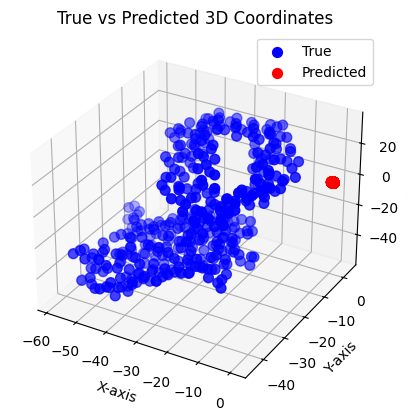

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(true_coords, predicted_coords):
    # Ensure true_coords is a NumPy array
    if isinstance(true_coords, torch.Tensor):
        true_coords = true_coords.detach().numpy()
    elif not isinstance(true_coords, np.ndarray):
        raise ValueError("true_coords must be a NumPy array or PyTorch tensor.")

    # Ensure predicted_coords is a NumPy array
    if isinstance(predicted_coords, torch.Tensor):
        predicted_coords = predicted_coords.detach().numpy()
    elif not isinstance(predicted_coords, np.ndarray):
        raise ValueError("predicted_coords must be a NumPy array or PyTorch tensor.")

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot true coordinates (blue)
    ax.scatter(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], c="blue", label="True", s=50)

    # Plot predicted coordinates (red)
    ax.scatter(predicted_coords[:, 0], predicted_coords[:, 1], predicted_coords[:, 2], c="red", label="Predicted", s=50)

    # Add titles and legend
    ax.set_title("True vs Predicted 3D Coordinates")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.legend()

    plt.show()

# Example Usage
true_coords_subset = coordinates[:predicted_coords.shape[0]]  # Slice to match predicted coordinates
plot_3d(true_coords_subset, predicted_coords)
